In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(2022)

## Forecast positif harian

In [5]:
data = pd.read_excel(
    "../../data/Daily Update Data Agregat Covid-19 Jakarta.xlsx", sheet_name="Data Jakarta")
positif_harian = data[["Tanggal", "Positif Harian"]]
positif_harian["Tanggal"] = pd.to_datetime(positif_harian["Tanggal"])
positif_harian.set_index("Tanggal", inplace=True)
positif_harian.head()

,Positif Harian
Tanggal,
2020-03-01,0
2020-03-02,0
2020-03-03,3
2020-03-04,0
2020-03-05,4


In [10]:
s = MinMaxScaler(feature_range=(0, 1))
positif_harian_scaled = s.fit_transform(positif_harian)

train_indices = len(positif_harian_scaled) * 0.8
test_indices = len(positif_harian_scaled) * 0.2
train_data = positif_harian_scaled[:int(train_indices)]
test_data = positif_harian_scaled[int(train_indices):]

print(train_data.shape, test_data.shape)

(680, 1) (171, 1)


In [17]:
def make_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

LOOK_BACK = 1
X_train, y_train = make_dataset(train_data, look_back=LOOK_BACK)
X_test, y_test = make_dataset(test_data, look_back=LOOK_BACK)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [19]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, LOOK_BACK)))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.1, callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

Epoch 1/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 1.1881e-05
Epoch 2/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 2.3801e-05
Epoch 3/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 8.1099e-05
Epoch 4/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 2.7005e-05
Epoch 5/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 8.1980e-05
Epoch 6/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 9.4750e-05
Epoch 7/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 6.6062e-06
Epoch 8/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 1.9347e-04
Epoch 9/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 1.0793e-05
Epoch 10/100
611/611 [==============================] -

<AxesSubplot:>

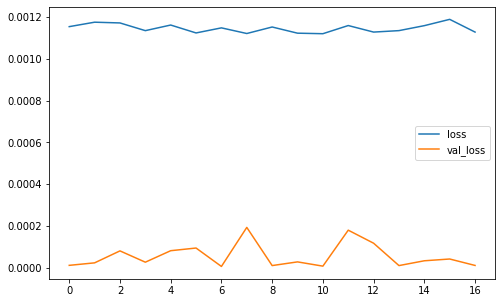

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

In [31]:
train_x_pred = model.predict(X_train)
test_x_pred = model.predict(X_test)

train_x_pred = s.inverse_transform(train_x_pred)
test_x_pred = s.inverse_transform(test_x_pred)

y_train_inversed = s.inverse_transform(y_train.reshape(-1, 1))
y_test_inversed = s.inverse_transform(y_test.reshape(-1, 1))

print(f"RMSE Train: {np.sqrt(mean_squared_error(y_train_inversed, train_x_pred))}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test_inversed, test_x_pred))}")

RMSE Train: 506.22216125119104
RMSE Test: 949.4605582795162


In [52]:
from pandas.tseries.offsets import DateOffset

future_data = [positif_harian.index[-1]+DateOffset(days=x) for x in range(0, 120)]
future_df = pd.DataFrame(future_data, columns=positif_harian.columns)
future_df_merge = pd.concat([positif_harian, future_df], axis=1)
len(future_df_merge)

971

In [55]:
future_df_merge

,Positif Harian,Positif Harian
1970-01-01 00:00:00.000000000,NaN,NaT
1970-01-01 00:00:00.000000001,NaN,NaT
1970-01-01 00:00:00.000000002,NaN,NaT
1970-01-01 00:00:00.000000003,NaN,NaT
1970-01-01 00:00:00.000000004,NaN,NaT
...,...,...
2022-06-25 00:00:00.000000000,1045.0,NaT
2022-06-26 00:00:00.000000000,1055.0,NaT
2022-06-27 00:00:00.000000000,838.0,NaT
2022-06-28 00:00:00.000000000,1250.0,NaT


In [54]:
future_df_merge["forecast"] = model.predict(future_df_merge[["Tanggal"]].values.reshape(-1, 1, 1))
future_df_merge["forecast"] = s.inverse_transform(future_df_merge["forecast"].reshape(-1, 1))
# future_df_merge.set_index("Tanggal", inplace=True)
future_df_merge.plot()

KeyError: "None of [Index(['Tanggal'], dtype='object')] are in the [columns]"